In [1]:
import xarray as xr

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap

import warnings 
warnings.filterwarnings(action='ignore')

# Data Load

In [2]:
path = './ndviavhrr19812001.nc'
ncfile = xr.open_dataset(path)
print(ncfile)

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 252)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2001-12-01
Data variables:
    data     (time, lat, lon) float32 ...
Attributes:
    history:     \nNational Aeronautics and Space Administration advanced ver...
    title:       NASA AVHRR normalized difference vegetation index, 1981-2001
    convention:  The file is written in COARDS-compliant netCDF:\nftp://ftp.u...


# Data Processing

In [3]:
ndvi = ncfile.data_vars['data']
print(ndvi.shape)

#Convert longitude coordinates from 0-359 to -180-179:
#https://xarray.pydata.org/en/stable/generated/xarray.Dataset.assign_coords.html
#Coordinate를 조정하거나 이미 있는 dimension에 대해 새롭게 coordinate를 만들어 줄 수도 있다. 
ndvi_ = ndvi.assign_coords({"lon" : (((ndvi.lon + 180) % 360) - 180)})
# "lon" : indicate longitude dimension.
#0-180 : (lon+180)-180 = lon 
#181-359 : (lon-180)-180 = lon-360
#ex) 5' => 5'  |  250 => -110

ndvi_ = ndvi_.sortby('lon')
#https://xarray.pydata.org/en/stable/generated/xarray.DataArray.sortby.html
#ascending = True -> 오름차순 (default), ascending = False -> 내림차순
#ascending = False를 뒤에 추가하면 179.5 178.5 ... -178.5 -179.5 로 찍힘.
#만약 sortby()를 안하게 되면 어떻게 될까?

print(ndvi_) #찍어보면 위에랑 longitude 좌표가 바뀐 것을 확인 할 수 있다. 

(252, 180, 360)
<xarray.DataArray 'data' (time: 252, lat: 180, lon: 360)>
[16329600 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2001-12-01
Attributes:
    units:      non-dimensional
    long_name:  NASA AVHRR normalized difference vegetation index, 1981-2001


### (1) Global Domain

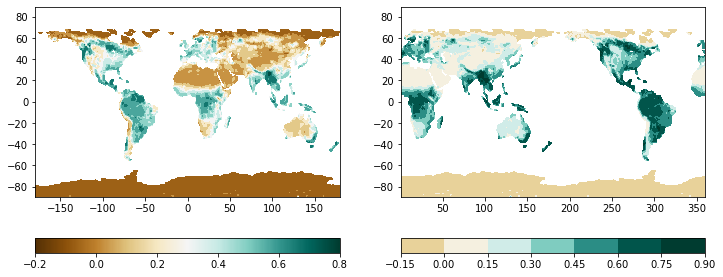

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ndvi_lat_convert = ax[0].contourf(ndvi_.lon, ndvi_.lat, ndvi_[10], cmap=plt.cm.BrBG,
                                 levels=10)
#colorbar 1 : plot단계에서 levels 지정하기
#cbar = fig.colorbar(ndvi_lat_convert, ax=ax[0], location = 'bottom')
#위 방법으로 colobar를 그리면 discrete한 형식으로 그려짐.

cmap = mpl.cm.BrBG
norm = mpl.colors.Normalize(vmin=-0.2, vmax=0.8)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax[0], orientation='horizontal')
#colorbar 2 : gradient로 그리기
#이렇게 하면 현재 ax[0]의 cbar처럼 gradient로 그릴 수 있음.
#다만 vmin과 vmax를 따로 지정해주어야함. method1처럼 data값을 인식해서 그리는 것이 아님.
#여기서는 먼저 discrete한 cbar을 그려서 최솟값과 최댓값을 확인한 후
#각 최솟값과 최댓값을 vmin, vmax로 지정해주었다. 
#출처 : https://matplotlib.org/stable/tutorials/colors/colorbar_only.html

ndvi_lat_original = ax[1].contourf(ndvi.lon, ndvi.lat, ndvi[10],cmap=plt.cm.BrBG)
ndvi_lat_original.set_clim(-0.5,0.75)
cbar2 = fig.colorbar(ndvi_lat_original,ax=ax[1], location = 'bottom')
#colorbar 3 : set_clim 사용하기.
#colorbar의 max, min값을 지정해 줄 수 있음. discrete한 형식.
#하지만 set_clim을 상위 matplot버전에서 지원하지 않는다고함..


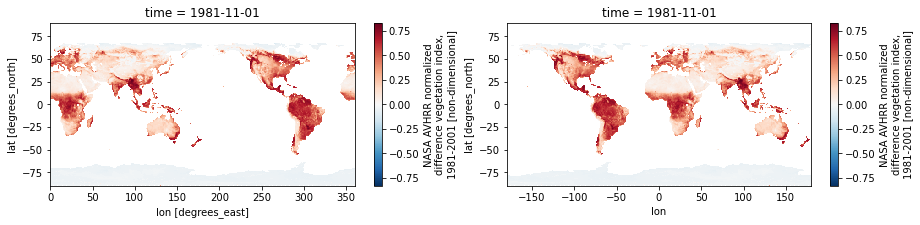

In [5]:
plt.figure(figsize=(15,3))
plt.subplot(1,2,1) ;ndvi[10].plot()
plt.subplot(1,2,2) ;ndvi_[10].plot()

### (2) Africa Domain

In [6]:
africa = ndvi_.sel(lon=slice(-30,60), lat=slice(40, -40))
print(africa.shape) #(time, lat, lon)
africa

(252, 80, 90)


<xarray.DataArray 'data' (time: 252, lat: 80, lon: 90)>
[1814400 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 39.5 38.5 37.5 36.5 35.5 ... -36.5 -37.5 -38.5 -39.5
  * lon      (lon) float32 -29.5 -28.5 -27.5 -26.5 -25.5 ... 56.5 57.5 58.5 59.5
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2001-12-01
Attributes:
    units:      non-dimensional
    long_name:  NASA AVHRR normalized difference vegetation index, 1981-2001

In [7]:
#climatology
africa_climatology = africa.groupby("time.month").mean("time")
print(africa_climatology.shape)

#anomaly
#NDVI - sum_of_NDVI(JAN_to_DEC)
africa_anomalies = africa_climatology - africa_climatology.mean("month")
#각 달의 climatology에서 전체 연평균을 뺀 거
print(africa_anomalies.shape)

print(africa_climatology)

(12, 80, 90)
(12, 80, 90)
<xarray.DataArray 'data' (month: 12, lat: 80, lon: 90)>
array([[[       nan,        nan,        nan, ..., 0.0447    ,
         0.04939999, 0.059     ],
        [       nan,        nan,        nan, ..., 0.04665   ,
         0.0399    , 0.03795   ],
        [       nan,        nan,        nan, ..., 0.0489    ,
         0.0626    , 0.11179999],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ..., 0.04715   ,
         0.05190001, 0.06459999],
        [       nan,        nan,        nan, ..., 0.06070001,
         0.0464    , 0.0399    ],
        [       nan,        nan,        nan, ..., 0.0445    ,
         0.06115   , 0.1306    ],
...
        [       nan,        nan,   

In [8]:
#Seasonal Progerssion
# NDVI - NDVI(mon-1)
#락훈오빠 방법과는 다른 방법.
#GrADS에서는 climatology를 직접 구하지 않고 
#이미 계산된 climatology nc file을 불러와서 계산하였음.

#print(africa_climatology)
lat = [ x for x in np.arange(39.5, -40.5, -1)]
lon = [ y for y in np.arange(-29.5, 60.5, 1)]
month = [ t for t in np.arange(1,13,1)]

data=africa_climatology.copy()
#만약 data = africa_africa_climatology 로 하면 어떻게 될까?
#(즉, copy() 안쓰면)

africa_progression = xr.DataArray(data, dims=["month","lat","lon"],
                                 coords=dict(
                                     month=("month",month),
                                     lon=("lon",lon),
                                     lat=("lat",lat),
                                     ),
                                  attrs=dict(description="NASA AVHRR normalized difference vegetation index, 1981-2001",
                                            units="non-dimensional"))

#africa_climatology data와 동일한 dimension을 가진
#africa_progression Data Array를 새롭게 만듦
#직접 coordinate랑 dimension, 설명, 단위도 지정해줌.

print(africa_progression[1])
#progression 연산 전 data값 확인

#africa_progression[0] = africa_climatology[0]- africa_climatology[1]
#africa_progression[0]

for t in range(0,12):
    if t==0:
        africa_progression[t] = (africa_climatology[t]- africa_climatology[-1])*10
    else:
        africa_progression[t] = (africa_climatology[t]-africa_climatology[t-1])*10
        
print(africa_progression[1])
#progression 연산 후 변한 data값 확인. 

<xarray.DataArray 'data' (lat: 80, lon: 90)>
array([[       nan,        nan,        nan, ..., 0.04715   , 0.05190001,
        0.06459999],
       [       nan,        nan,        nan, ..., 0.06070001, 0.0464    ,
        0.0399    ],
       [       nan,        nan,        nan, ..., 0.0445    , 0.06115   ,
        0.1306    ],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
    month    int32 2
  * lon      (lon) float64 -29.5 -28.5 -27.5 -26.5 -25.5 ... 56.5 57.5 58.5 59.5
  * lat      (lat) float64 39.5 38.5 37.5 36.5 35.5 ... -36.5 -37.5 -38.5 -39.5
Attributes:
    description:  NASA AVHRR normalized difference vegetation index, 1981-2001
    units:        non-dimensional
<xarray.DataArray 'data' (lat: 80, lon: 90)

# Visualization

### (0) Plot NDVI function

In [9]:
def plot_africa_NDVI(clim_ano_prog, ax, month):
    m = Basemap(
        lon_0 = 0, lat_0 = 0, 
        llcrnrlon=-30, llcrnrlat=-40, urcrnrlon=60, urcrnrlat=40,
        resolution='h',
        ax=ax)
    
    index=month-1
    coord = np.meshgrid(clim_ano_prog.lon, clim_ano_prog.lat)
    
    m.drawcoastlines(linewidth=0.5, color='k')
    m.drawcountries(linewidth=0.5, color='k') # draw country line
    m.drawparallels(np.linspace(-40,40,5), labels=[1,0,0,0], linewidth=0., fontsize=5) # draw horizontal grid line
    m.drawmeridians(np.linspace(-30,60,5), labels=[0,0,0,1], linewidth=0., fontsize=5) # draw vertical grid line
    ndvi_contourf = m.contourf(coord[0], coord[1], clim_ano_prog[index],cmap=plt.cm.BrBG,
                              levels = 20)
    ax.set_title(month)
    
    return ndvi_contourf

### (1) Climatology 

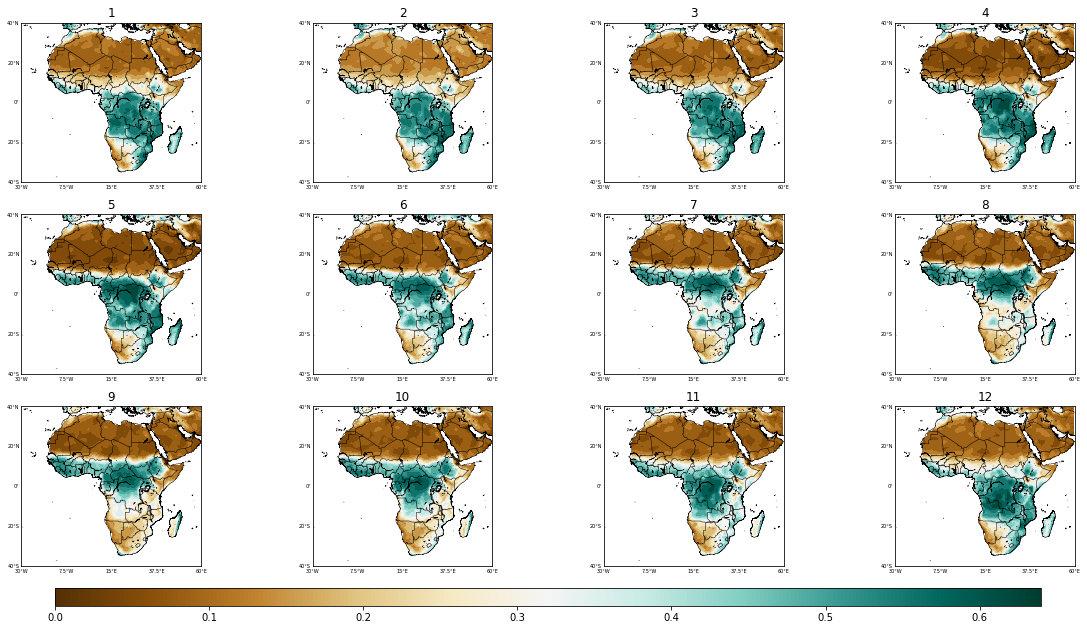

In [10]:
nrow = 3
ncol = 4
fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(20,10))
#plt.subplots_adjust(wspace=0.0, hspace=0.2)


mo = 1
for row in range(3):
    for col in range(4):
        plot = plot_africa_NDVI(africa_climatology,ax[row][col], mo)
        mo+=1

cbar_ax = fig.add_axes([0.17, 0.07, 0.685, 0.025])
#cbar_ax가 들어갈 영역 설정

cmap = mpl.cm.BrBG
norm = mpl.colors.Normalize(vmin=0., vmax=0.64)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='horizontal')
#what is cax?

### (2) Anomaly

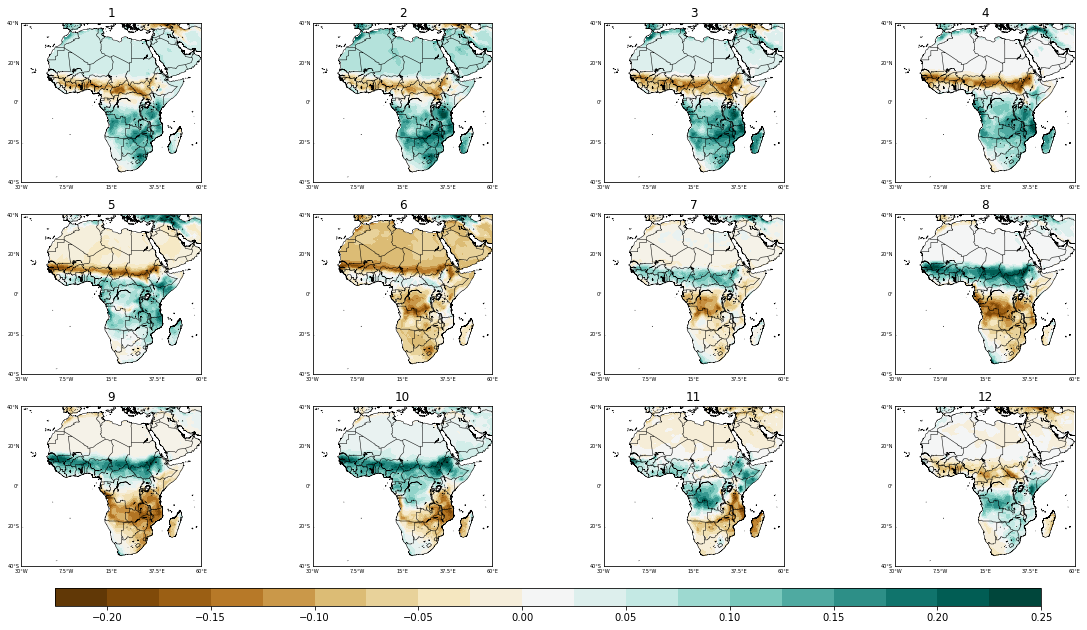

In [11]:
nrow = 3
ncol = 4
fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(20,10))
#plt.subplots_adjust(wspace=0.0, hspace=0.2)


mo = 1
for row in range(3):
    for col in range(4):
        plot = plot_africa_NDVI(africa_anomalies,ax[row][col], mo)
        mo+=1

cbar_ax = fig.add_axes([0.17, 0.07, 0.685, 0.025])
cbar = plt.colorbar(plot, cax=cbar_ax, orientation="horizontal")

plt.show()       

### (3) Seasonal progression (data * 10)

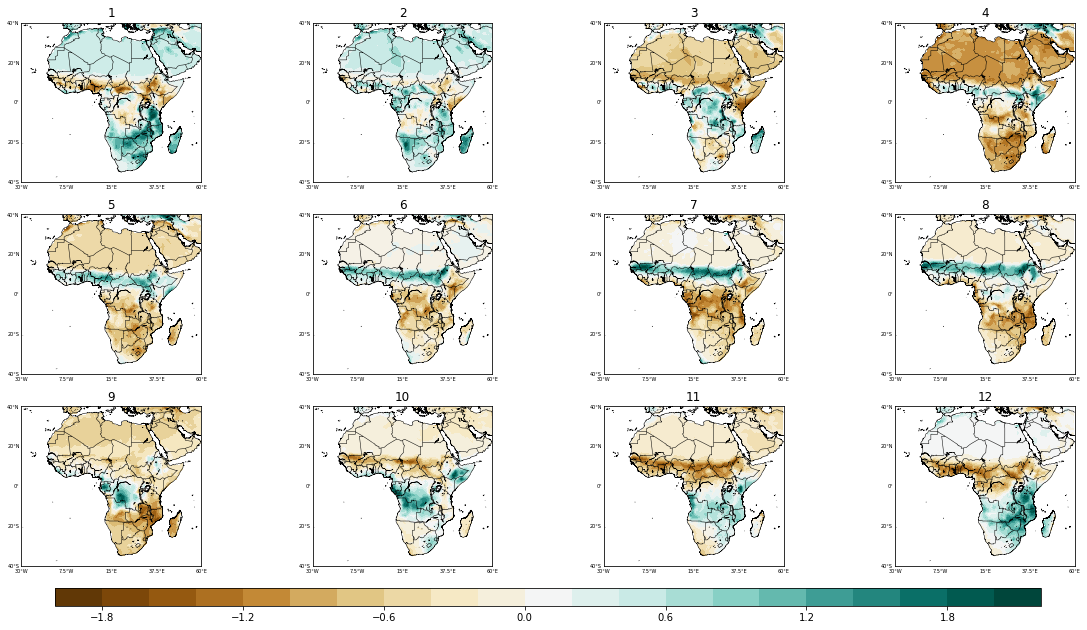

In [13]:
nrow = 3
ncol = 4
fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(20,10))
#plt.subplots_adjust(wspace=0.0, hspace=0.2)


mo = 1
for row in range(3):
    for col in range(4):
        plot = plot_africa_NDVI(africa_progression,ax[row][col], mo)
        mo+=1

cbar_ax = fig.add_axes([0.17, 0.07, 0.685, 0.025])
cbar = fig.colorbar(plot, cax=cbar_ax, orientation='horizontal')

plt.show()       